# Bivariate Analysis

### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

In [2]:
# Set Plotly default template
pio.templates.default = "plotly_white"

### Loading the Datasets

In [3]:
df_enrolment = pd.read_parquet('enrolment_cleaned.parquet')
df_demographic = pd.read_parquet('demographic_cleaned.parquet')
df_biometric = pd.read_parquet('biometric_cleaned.parquet')

### Prepare Aggregate Datasets

In [4]:
# 1. Aggregation by State
state_enrol = df_enrolment.groupby('state').size().reset_index(name='Enrolment_Count')
state_demo = df_demographic.groupby('state').size().reset_index(name='Demographic_Update_Count')
state_bio = df_biometric.groupby('state').size().reset_index(name='Biometric_Update_Count')

# Merge into a single dataframe
df_state_merged = state_enrol.merge(state_demo, on='state', how='outer') \
                             .merge(state_bio, on='state', how='outer').fillna(0)

# 2. Aggregation by Date
date_enrol = df_enrolment.groupby('date').size().reset_index(name='Enrolment_Count')
date_demo = df_demographic.groupby('date').size().reset_index(name='Demographic_Update_Count')
date_bio = df_biometric.groupby('date').size().reset_index(name='Biometric_Update_Count')

df_date_merged = date_enrol.merge(date_demo, on='date', how='outer') \
                           .merge(date_bio, on='date', how='outer').fillna(0)

### Correlation Analysis
##### To determine if enrolment volume is correlated with update volume.

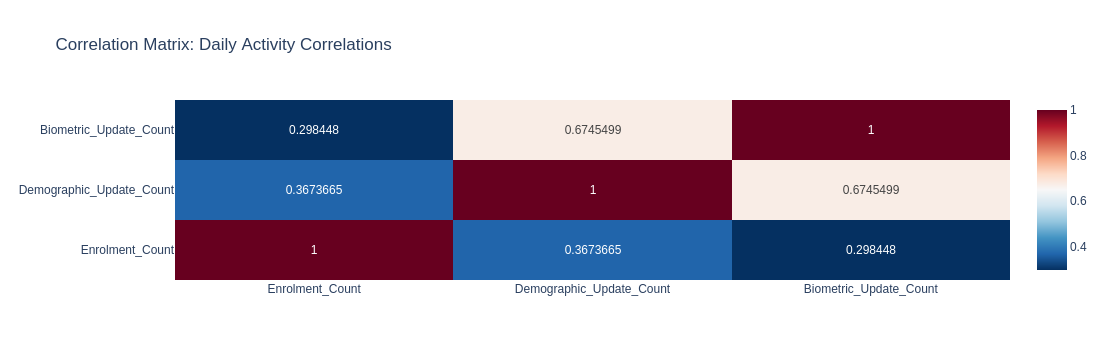

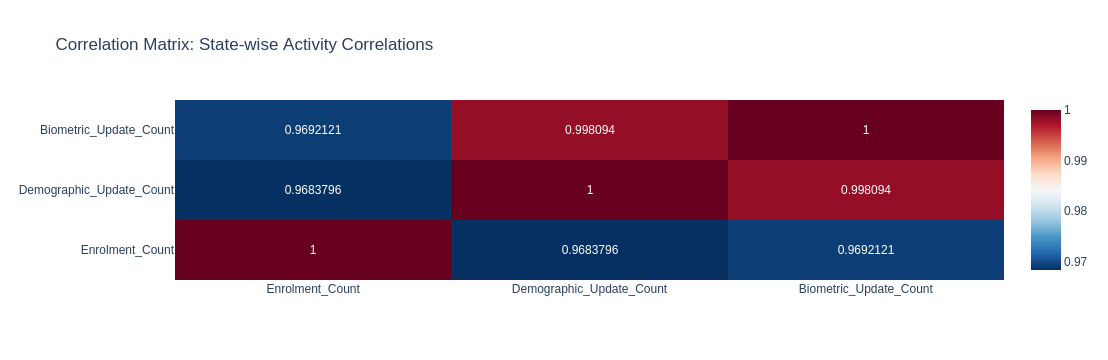

In [5]:
def plot_correlation_heatmap(df, title):
    # Calculate correlation matrix
    corr_matrix = df.corr(numeric_only=True)
    
    # Plot Heatmap
    fig = px.imshow(
        corr_matrix,
        text_auto=True,
        aspect="auto",
        color_continuous_scale='RdBu_r', # Red-Blue diverging scale
        title=f"Correlation Matrix: {title}",
        origin='lower'
    )
    fig.show()

# Analyze correlation over TIME
plot_correlation_heatmap(df_date_merged, "Daily Activity Correlations")

# Analyze correlation by GEOGRAPHY
plot_correlation_heatmap(df_state_merged, "State-wise Activity Correlations")

### State-wise Enrolment v/s Updates
##### To determine if states behave differently

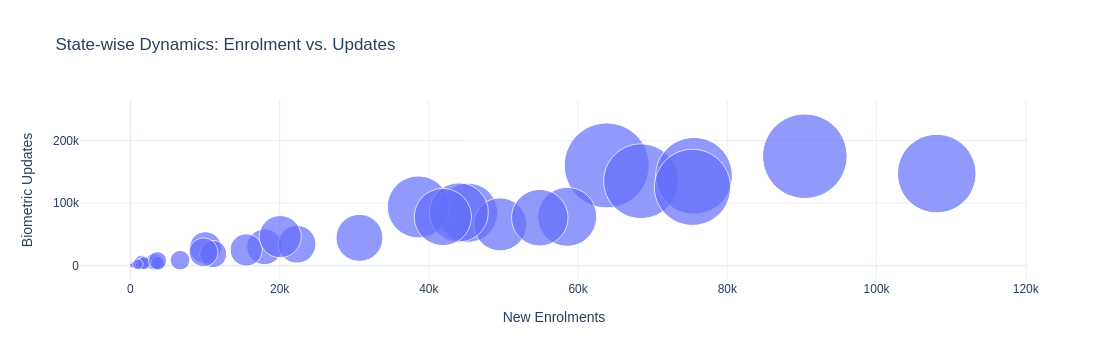

In [10]:
def plot_state_comparison(df):
    # Scatter plot: Enrolment (X) vs Biometric Updates (Y)
    # Bubble size = Demographic Updates
    
    fig = px.scatter(
        df,
        x="Enrolment_Count",
        y="Biometric_Update_Count",
        size="Demographic_Update_Count",
        hover_name="state",
        title="State-wise Dynamics: Enrolment vs. Updates",
        labels={
            "Enrolment_Count": "New Enrolments",
            "Biometric_Update_Count": "Biometric Updates",
            "Demographic_Update_Count": "Demographic Volume"
        },
        size_max=60
    )
    
    # Improve readability
    fig.update_traces(textposition='top center')
    fig.show()

plot_state_comparison(df_state_merged)

### Temporal Patterns: Weekday vs. Weekend
##### To see if the day of the week affects service demand differently for enrolments vs updates.

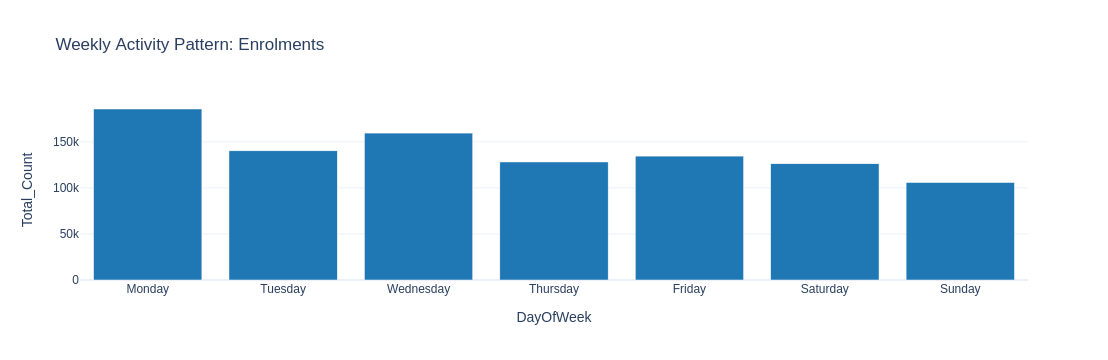

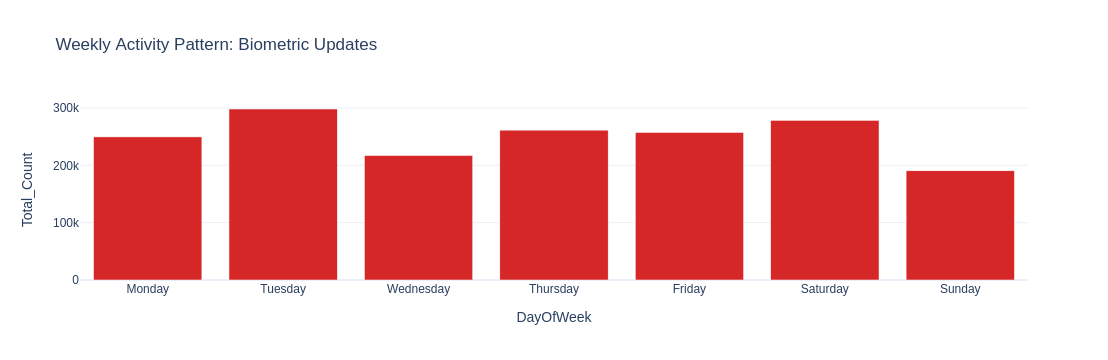

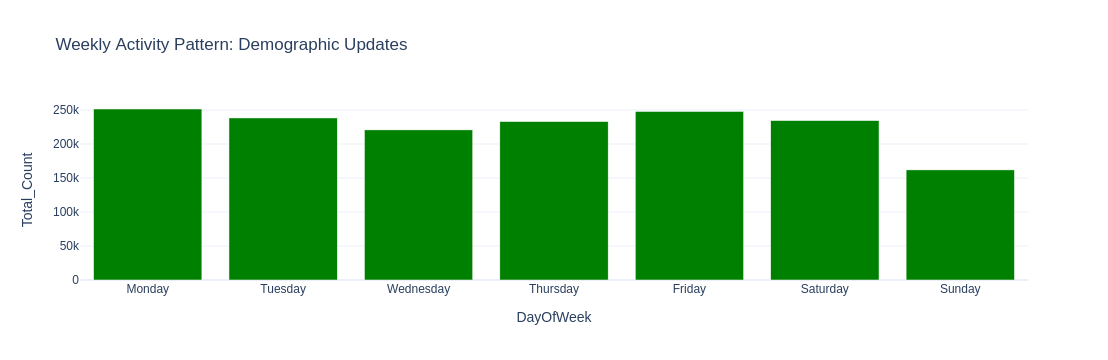

In [13]:
def analyze_weekly_patterns(df, activity_name, color):
    # Ensure date is datetime
    df['date'] = pd.to_datetime(df['date'])
    
    # Extract Day of Week (0=Monday, 6=Sunday)
    df['DayOfWeek'] = df['date'].dt.day_name()
    
    # Sort order
    order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    
    # Aggregate
    daily_avg = df.groupby('DayOfWeek').size().reset_index(name='Total_Count')
    
    # Normalize to get "Average per day" to account for dataset imbalances
    fig = px.bar(
        daily_avg,
        x='DayOfWeek',
        y='Total_Count',
        category_orders={"DayOfWeek": order},
        title=f"Weekly Activity Pattern: {activity_name}",
        color_discrete_sequence=[color]
    )
    fig.show()

analyze_weekly_patterns(df_enrolment, "Enrolments", "#1f77b4")
analyze_weekly_patterns(df_biometric, "Biometric Updates", "#d62728")
analyze_weekly_patterns(df_demographic, "Demographic Updates", "green")

### Regional Patterns (Pincode Proxy)
##### To use the first digit of the Pincode (Zip Code) as a proxy for the region/zone to compare Urban vs. Rural or Regional differences

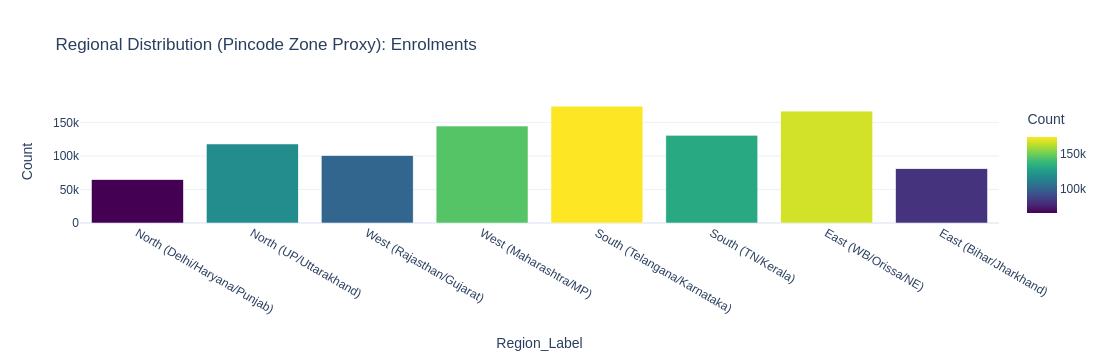

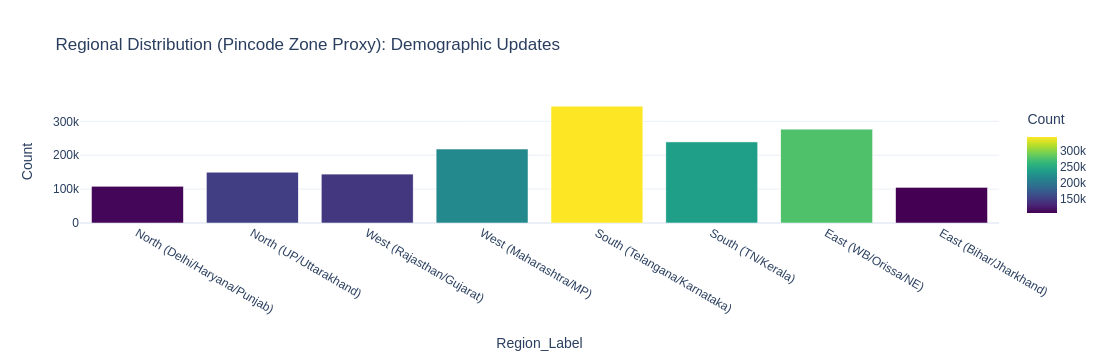

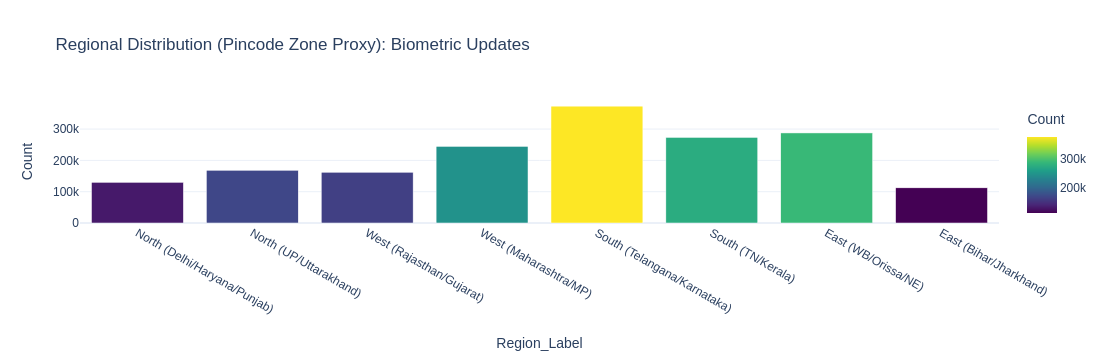

In [14]:
def analyze_pincode_zones(df, dataset_name):
    # Extract First Digit of Pincode
    df['Pin_Zone'] = df['pincode'].astype(str).str[0]
    
    # Filter for valid zones (1-9)
    valid_zones = [str(i) for i in range(1, 10)]
    df_zone = df[df['Pin_Zone'].isin(valid_zones)]
    
    zone_counts = df_zone.groupby('Pin_Zone').size().reset_index(name='Count')
    
    # Mapping Zone numbers to Regions (General approximation)
    zone_map = {
        '1': 'North (Delhi/Haryana/Punjab)',
        '2': 'North (UP/Uttarakhand)',
        '3': 'West (Rajasthan/Gujarat)',
        '4': 'West (Maharashtra/MP)',
        '5': 'South (Telangana/Karnataka)',
        '6': 'South (TN/Kerala)',
        '7': 'East (WB/Orissa/NE)',
        '8': 'East (Bihar/Jharkhand)',
        '9': 'Army/Field PO'
    }
    zone_counts['Region_Label'] = zone_counts['Pin_Zone'].map(zone_map)
    
    fig = px.bar(
        zone_counts,
        x='Region_Label',
        y='Count',
        title=f"Regional Distribution (Pincode Zone Proxy): {dataset_name}",
        color='Count',
        color_continuous_scale='Viridis'
    )
    fig.show()

analyze_pincode_zones(df_enrolment, "Enrolments")
analyze_pincode_zones(df_demographic, "Demographic Updates")
analyze_pincode_zones(df_biometric, "Biometric Updates")

### Age Group Cross-Tabulation
##### Compare how different age groups interact with different services.

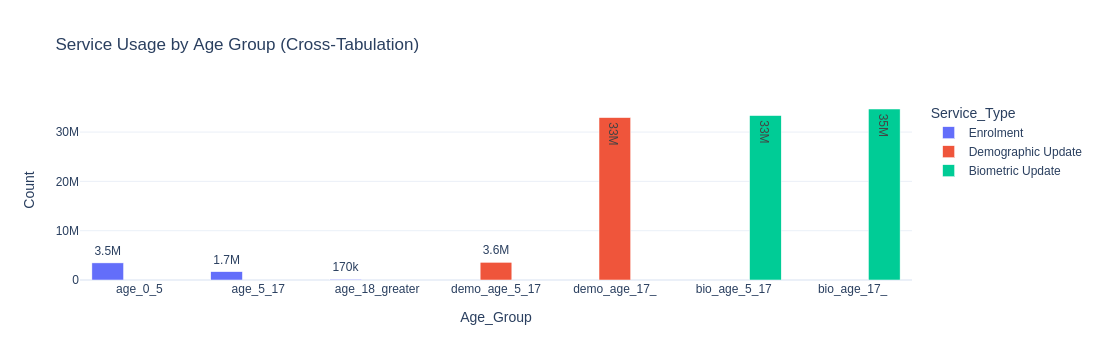

In [15]:
def compare_age_services(df_enrol, df_demo, df_bio):
    # Helper to sum age columns
    def get_age_sums(df, label):
        age_cols = [c for c in df.columns if 'age' in c.lower()]
        sums = df[age_cols].sum().reset_index()
        sums.columns = ['Age_Group', 'Count']
        sums['Service_Type'] = label
        return sums

    # Combine all datasets
    s1 = get_age_sums(df_enrol, 'Enrolment')
    s2 = get_age_sums(df_demo, 'Demographic Update')
    s3 = get_age_sums(df_bio, 'Biometric Update')
    combined = pd.concat([s1, s2, s3])

    fig = px.bar(
        combined,
        x="Age_Group",
        y="Count",
        color="Service_Type",
        barmode="group",
        title="Service Usage by Age Group (Cross-Tabulation)",
        text_auto='.2s'
    )
    fig.show()

compare_age_services(df_enrolment, df_demographic, df_biometric)